In [66]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pathlib import Path
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

In [67]:
positive_dir = Path('../input/surface-crack-detection/Positive')
negative_dir = Path('../input/surface-crack-detection/Negative')

# **Creat DataFrame**

In [68]:
def generate_df(image_dir, label):
    #Find certain pattern in the file path
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str) 
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [69]:
positive_df = generate_df(positive_dir, label="POSITIVE")
negative_df = generate_df(negative_dir, label="NEGATIVE")
#Concatenate and shuffled two of DataFrames on top of each others
all_df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
all_df.head

<bound method NDFrame.head of                                                 Filepath     Label
0      ../input/surface-crack-detection/Positive/0574...  POSITIVE
1      ../input/surface-crack-detection/Positive/1870...  POSITIVE
2      ../input/surface-crack-detection/Positive/0967...  POSITIVE
3      ../input/surface-crack-detection/Negative/0791...  NEGATIVE
4      ../input/surface-crack-detection/Positive/1400...  POSITIVE
...                                                  ...       ...
39995  ../input/surface-crack-detection/Positive/0854...  POSITIVE
39996  ../input/surface-crack-detection/Negative/1944...  NEGATIVE
39997  ../input/surface-crack-detection/Positive/0977...  POSITIVE
39998  ../input/surface-crack-detection/Positive/1504...  POSITIVE
39999  ../input/surface-crack-detection/Negative/1099...  NEGATIVE

[40000 rows x 2 columns]>

In [70]:
train_df, test_df = train_test_split(
    all_df.sample(7000, random_state=1),
    train_size=0.7,
    shuffle=True,
    random_state=1
)

# **Import image data**

In [71]:
#Creating two data generator
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, #Scalling all the pixel values down to the range of 0 and 1
    validation_split=0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [72]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120), #rescaling it for saving time and memory 
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'#80 percent of the train_gen is for train_data 
)

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb', #rgb standard
    class_mode='binary', #There are only two classes positive and negative
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'#20 percent of the train_gen reserve for train_data 
)

test_data = train_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 3920 validated image filenames belonging to 2 classes.
Found 980 validated image filenames belonging to 2 classes.
Found 2100 validated image filenames belonging to 2 classes.


# **Training**

In [73]:
#Feature extraction
inputs = tf.keras.Input(shape=(120, 120, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x) #redyce the size of the output
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)

#Classification
x = tf.keras.layers.GlobalAveragePooling2D()(x) #reducing down two one dimention with averages across all rows
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 118, 118, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 59, 59, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 57, 57, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 28, 28, 32)        0         
_________________________________________________________________
global_average_pooling2d_6 ( (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33  

In [74]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
123/123 [==============================] - 26s 206ms/step - loss: 0.6869 - accuracy: 0.5287 - val_loss: 0.6304 - val_accuracy: 0.6480
Epoch 2/100
123/123 [==============================] - 24s 198ms/step - loss: 0.6017 - accuracy: 0.7238 - val_loss: 0.5025 - val_accuracy: 0.8367
Epoch 3/100
123/123 [==============================] - 24s 196ms/step - loss: 0.4685 - accuracy: 0.8406 - val_loss: 0.3673 - val_accuracy: 0.9184
Epoch 4/100
123/123 [==============================] - 24s 197ms/step - loss: 0.3373 - accuracy: 0.9228 - val_loss: 0.2894 - val_accuracy: 0.9194
Epoch 5/100
123/123 [==============================] - 24s 197ms/step - loss: 0.2583 - accuracy: 0.9399 - val_loss: 0.2107 - val_accuracy: 0.9592
Epoch 6/100
123/123 [==============================] - 24s 196ms/step - loss: 0.2037 - accuracy: 0.9545 - val_loss: 0.1803 - val_accuracy: 0.9704
Epoch 7/100
123/123 [==============================] - 24s 196ms/step - loss: 0.1652 - accuracy: 0.9661 - val_loss: 0.1557 -

In [75]:
fig = px.line(
    history.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epoch", 'value': "Loss"},
    title="Training and Validation Loss Over Time"
)

fig.show()

# **Results**

In [76]:
def evaluate_model(model, test_data):
    
    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    acc = results[1]
    
    print("    Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))
    
    y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int)) #predicted values
    cm = confusion_matrix(test_data.labels, y_pred) #compare a set of true lable values and a set of predicted values
    clr = classification_report(test_data.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)

    Test Loss: 0.06374
Test Accuracy: 97.76%


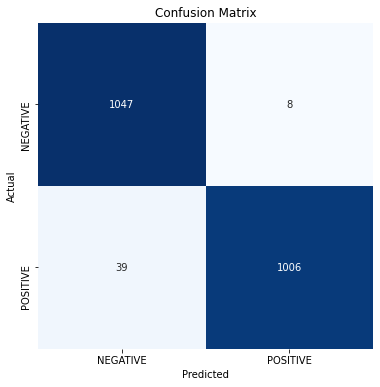

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.96      0.99      0.98      1055
    POSITIVE       0.99      0.96      0.98      1045

    accuracy                           0.98      2100
   macro avg       0.98      0.98      0.98      2100
weighted avg       0.98      0.98      0.98      2100



In [77]:
evaluate_model(model, test_data)